<a href="https://colab.research.google.com/github/dmaxim/ufl-ai/blob/main/overfitting_diag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# diagnosing model overfitting

You can find a supplemental video on this exercise [here](https://youtu.be/K4_G7LUNt3E)

Your model is "overfitting" your training data when it starts to 'fit' the 'error' in the data, rather than fitting the general 'pattern'. When this happens, the model becomes 'specific' to the *particular* data set you used to train it, and it won't "generalize" well to *new* data.

We can 'exploit' what overfitting 'looks like' to develop a 'diagnostic' for determining if a model is 'overfit' or not.

We just need *two* data sets:

* __training data__ to fit the parameters of the model
* __validation data__ to 'check' if the fit model 'generalizes' to new data

If the model performs roughly *the same* on the training and validation data, then the model is probably *not* overfitting the training data. However, if the model performs *much better* on the *training* data, it is probably overfitting.

How do we measure the model's 'performance'?

Well, we *already* have the "loss function", which tells us how well the model's predictions 'fit' the 'real' response values. We can use the *same* loss function that we use to fit the model to the training data to evaluate the model's performance on the validation data.

So, our "overfitting diagnostic" procedure will go something like this:

1. Partition the data into 2 sub-sets: training and validation
2. Fit the model to the training data and evaluate the "training loss"
3. Evaluate the model's "validation loss" using the validation data
4. If the validation loss is *much higher* than the training loss, the model is "overfit" to the training data (here we assume that *lower* loss is *better*, which it usually is). Otherwise, if the validation loss and the training loss are *about the same*, we can conclude that the model is probably not overfitting the training data.

This diagnostic procedure is *widely used* in AI and machine learning, so tensorflow and other libraries have *built in procedures* to help facilitate its use.

First, we need to partition our data into training and validation sub-sets. We'll start by simulating some data.

In [1]:
import sklearn.datasets

x,y = sklearn.datasets.make_regression(n_samples=100,
                                       n_features=1,
                                       bias=100.0,
                                       noise=10.0,
                                       random_state=201188)

y /= 100.0

And we can plot our data, as before.

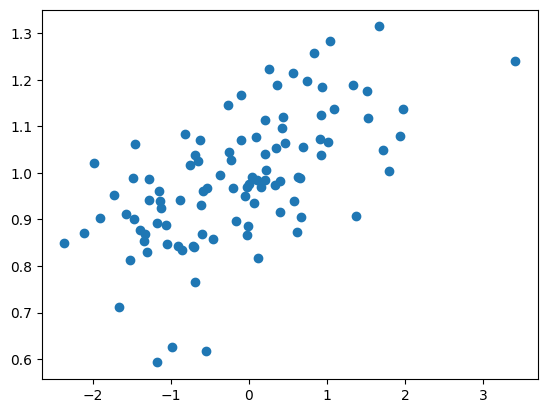

In [2]:
import matplotlib.pyplot as plt

plt.scatter(x,y, marker='o')

These are pretty 'noisy' data, but it is what it is. We can't 'decide' what data we'll get, only how we'll analyze it.

## splitting data into training and validation sub-sets

Now let's 'split' or "partition" our existing data into training and validation sub-sets. This 'mimics' the procedure of going out and collecting an entirely *new* data set for validation.

If this were a *real* data analysis, we would want to be *extremely careful* about how we partition our data into training and validation sub-sets, so we don't 'fool' ourselves into thinking our model is doing well, when in fact it isn't. We want our validation to be a fair and realistic assessment of our model's expected performance on new data.

In general, we want our validation data set to have a couple important properties:

* We want the validation data to be "representative" of the "entire" data set. We *don't* want the validation data to *only* represent a narrow range of x- or y-values; we want it to span the *entire range* of both x- and y-values.
* We want the validation data to be "independent" of the training data. Ideally, the validation data should represent an entirely *new* and independent data sample from the same underlying distribution as the training data. If the validation data samples are *too similar* to the training samples, the validation data and the training data are 'essentially the same', and the validation data no longer represents a good way to test how the model will perform on 'new' data.

For now, we'll just 'randomly' partition our data into training and validation sub-sets, and then do a quick 'check' to see if our random partition is okay. This is probably the most common approach used in AI and machine learning.

It's so common that scikit-learn has a function that does it for us!

We just need to decide *how much* of the original data we want to set aside for validation. Typically, we'd set aside somewhere between 10% and 40% of the data for validation, based on the size of the original data set. When the data set is 'smaller', we would typically set aside a *larger proportion* of the data for validation (20-40%), whereas a 'larger' data set would only require a *small proportion* of validation data.

In our case, we'll decide to use 20% of the data for validation.

The scikit-learn function that partitions data into training and validation sub-sets is called "train_test_split", and it's in the "sklearn.model_selection" sub-module. Just be aware that scikit-learn is using the term, "test" to refer to "validation".

In [3]:
import sklearn.model_selection

train_x, valid_x, train_y, valid_y = sklearn.model_selection.train_test_split(x,
                                                                              y,
                                                                              test_size=0.2,
                                                                              random_state=221882)

Here, we supply the "train_test_split" function with our *original* explanatory and response variables (x and y, respectively), and we set the

    test_size=0.2

option to use 20% of the original data for the "test" data, which is actually "*validation*" data!

We also set the "random_state" option to some integer value, just so we can reproduce the *same* data split many times.

The "train_test_split" function returns *4* values, in order:

1. training data explanatory variables (train_x, in our example)
2. validation data explanatory variables (valid_x)
3. training data response variables (train_y)
4. validation data response variables (valid_y)

We've captured the output of the "train_test_split" function call in these four variables, so we can use them later on.

Let's plot the training and validation data sub-sets, to see how they look.

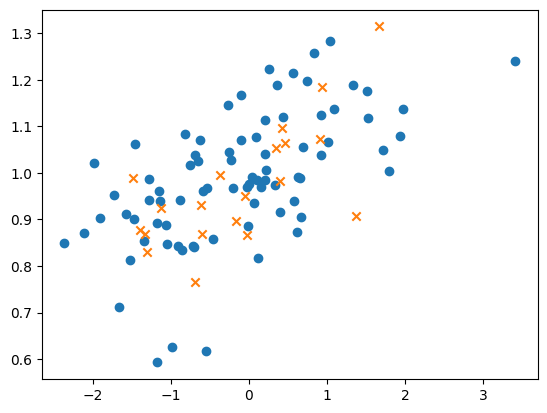

In [4]:
plt.scatter(train_x, train_y, marker='o')
plt.scatter(valid_x, valid_y, marker='x')

Here, we're plotting the training data as blue circles and the validation data as orange xs.

For this particular split, it seems like the validation data represents *most of* the range of both the x- and y-axes, although the orange xs do appear to be a little clustered in the *center* of the graph. Importantly, the orange xs are *not* right on top of blue circles, so the validation data appears relatively *independent* of the training data.

## building the neural network model

The neural network model is *exactly the same*, whether you are using validation data or not. So, let's just build a simple linear model for now.

In [5]:
import tensorflow as tf

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=1, input_shape=[1]))
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.MeanSquaredError())
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 2 (8.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


done. We used the stochastic gradient descent optimizer (SGD) and mean-squared error loss function, as before.

## packaging data and fitting the model

Packaging the data into a Dataset object for tensorflow is also *exactly* the same as before, although now we need *two* different Dataset objects: one will hold the training data, and the other will hold the validation data.

In [6]:
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(10)
valid_data = tf.data.Dataset.from_tensor_slices((valid_x, valid_y)).batch(10)

Should look pretty familiar. As before, we 'batched' our data using a batch size of 10.

Let's fit the model.

In this case, we need an *additional* option to the "model.fit" method call, supplying the *validation* data to the model, which will calculate an *additional* loss score as the model is trained.

In [7]:
model.fit(train_data, epochs=100, validation_data=valid_data)

Epoch 1/100
8/8 [==============================] - 1s 21ms/step - loss: 0.9088 - val_loss: 0.7118
Epoch 2/100
8/8 [==============================] - 0s 4ms/step - loss: 0.6522 - val_loss: 0.5083
Epoch 3/100
8/8 [==============================] - 0s 4ms/step - loss: 0.4703 - val_loss: 0.3640
Epoch 4/100
8/8 [==============================] - 0s 3ms/step - loss: 0.3409 - val_loss: 0.2617
Epoch 5/100
8/8 [==============================] - 0s 3ms/step - loss: 0.2487 - val_loss: 0.1889
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 0.1828 - val_loss: 0.1371
Epoch 7/100
8/8 [==============================] - 0s 4ms/step - loss: 0.1355 - val_loss: 0.1002
Epoch 8/100
8/8 [==============================] - 0s 3ms/step - loss: 0.1015 - val_loss: 0.0739
Epoch 9/100
8/8 [==============================] - 0s 4ms/step - loss: 0.0771 - val_loss: 0.0551
Epoch 10/100
8/8 [==============================] - 0s 5ms/step - loss: 0.0594 - val_loss: 0.0417
Epoch 11/100
8/8 [==========

The *only* new addition to the "model.fit" method call is the

    validation_data=valid_data

option, where we supply the tensorflow model with the packaged validation data set ("valid_data"). Tensorflow will handle all the rest!

When you fit the model, you will see that tensorflow reports the "loss:", just like before, during each epoch of training. This is the model's loss on the *training* data, which we are using to fit the model's parameters.

In addition, tensorflow reports the "val_loss:", which is the *same* loss function, calculated using the *validation* data set.

We can track the "loss" to evaluate the model's fit to the training data as it trains, and we can track the "val_loss" to evaluate the model's expected loss on *new* validation data.

In this particular case, we see that the loss on the *training data* reaches a minimum of around 0.0127 (in my case; your results may vary a little bit). The loss on the *validation data* is very similar (0.0091, in my case) to the training loss, suggesting that the simple linear model is *not* overfitting to the training data.

As before, we can plot the fit model against the data, just to check.

4/4 [==============================] - 0s 2ms/step


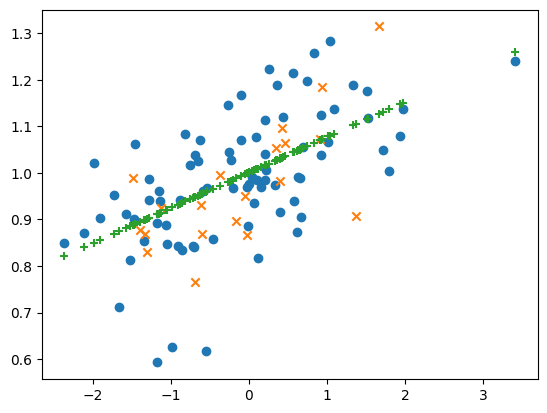

In [8]:
y_hat = model.predict(x)

plt.scatter(train_x, train_y, marker='o')
plt.scatter(valid_x, valid_y, marker='x')
plt.scatter(x, y_hat, marker='+')

As before, the blue circles are the training data, and the orange xs are the validation data. The green +s are the model's predictions for the *entire* data set (x).

## evaluating model overfitting end-to-end example

Now that we've got the 'basics' of evaluating model overfitting, let's try it out using a more complex model.

The following code cell is an end-to-end example, with a few missing pieces you'll need to fill in.

We've 'upped the ante' a little bit by simulating 2-dimensional explanatory variables. Notice the

    n_features=2

option in the "make_regression" function call at the beginning?

Not a problem; the *only* thing we need to change in our neural network is the

    input_shape=[2]

option in the *first* network layer, which was "input_shape=[1]" in the 1-dimensional case.

And of course, we need to plot the data in 3 dimensions, which is a bit more tricky than plotting in 2D. But the plotting isn't really part of this course; it's just there so you can visualize your data and model fit.

You should edit the parts of the code cell that say,

    FIXME

to implement the following required functionality:

* partition your simulated data into 80% training data and 20% validation data
* package training and validation data into tensorflow Dataset objects with batch size 10
* fit your model to the training data using 500 epochs of training; include model evaluation using the validation data

Then run the code cell to fit and evaluate your model. Make a note of the final model's loss on the training data and val_loss on the validation data; you will likely need those numbers for the quiz.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 64)                192       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8577 (33.50 KB)
Trainable params: 8577 (33.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/1000
8/8 [==============================] - 1s 15ms/step - loss: 1.5580 - val_loss: 0.6015
Epoch 2/1000
8/8 [==============================] - 0

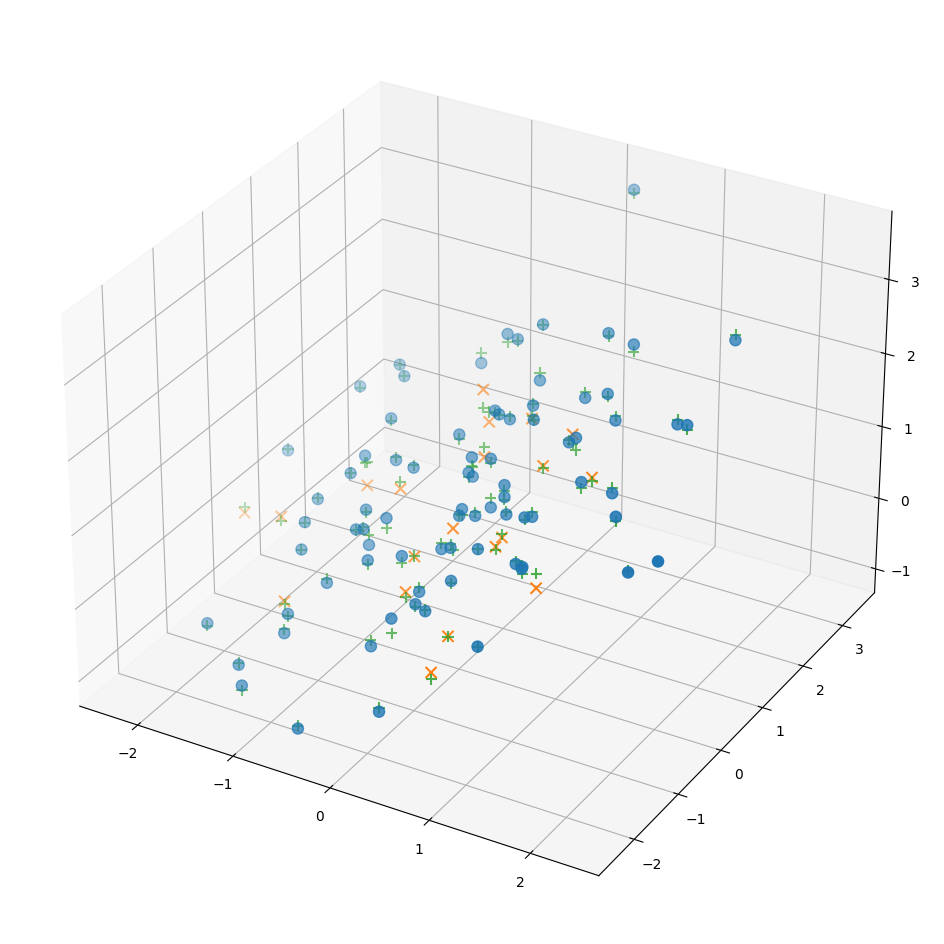

In [10]:
import sklearn.datasets
import sklearn.model_selection
import matplotlib.pyplot as plt
import tensorflow as tf

# simulate data
x,y = sklearn.datasets.make_regression(n_samples=100,
                                       n_features=2,
                                       bias=100.0,
                                       noise=10.0,
                                       random_state=201188)
y /= 100.0

# partition your simulated data into 80% training data and 20% validation data
train_x, valid_x, train_y, valid_y = sklearn.model_selection.train_test_split(x,
                                                                              y,
                                                                              test_size=0.2,
                                                                              random_state=221882)

# package training and validation data into tensorflow Dataset objects
# with batch size 10
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(10)
valid_data = tf.data.Dataset.from_tensor_slices((valid_x, valid_y)).batch(10)

# build model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=64, activation=tf.keras.activations.relu, input_shape=[2]))
model.add(tf.keras.layers.Dense(units=64, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(units=64, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(units=1))

model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.MeanSquaredError())
model.summary()

# fit your model to the training data using 500 epochs of training;
# include model evaluation using the validation data
model.fit(train_data, epochs=500, validation_data=valid_data)

# predict using fitted model
y_hat = model.predict(x)

# plot data and model fit
fig = plt.figure(figsize=(12,12))
axs = fig.add_subplot(projection='3d')
axs.scatter(train_x[:,0], train_x[:,1], train_y, marker='o', s=64)
axs.scatter(valid_x[:,0], valid_x[:,1], valid_y, marker='x', s=64)
axs.scatter(x[:,0], x[:,1], y_hat, marker='+', s=64)

Is the model's loss on the validation data higher or lower than its loss on the training data?

What does that mean for model overfitting?

In the 3D plot, the training data are indicated by blue circles. The validation data are indicated by orangs xs, and the model's predicted responses for *all* the data are indicated by green +s.

Do you notice a lot of cases in which the green + (model's predicted response) is *exactly* on top of the corresponding blue circle (training data)? These will look like "&oplus;". Such a *precise* correspondence between predicted and true response values *on the training data* is a pretty good indication of model overfitting.

Also, if you scroll back through the output of the training process, you might notice that the model's loss *on the training data* never actually plateaus; it keeps getting *better and better* as the model trains. Not convinced? Try editing the code cell to train the model for 1000 epochs, and see if the model's loss improves further.

While the model's loss on the training data doesn't *have to* plateau, the failure of the model to find a *stable* loss during training is a *potential* 'red flag' that could indicate overfitting or some other problem with the training process. Incidentally, the *presence* of a loss plateau can *also* indicate a potential problem with the training process, especially when the model is not performing well; it can often indicate that the model is 'stuck' in a 'local optimum'.

## a note on 3-way train-validate-test splits

In our data analyses so far, we have been using a *single, pre-determined* neural network to analyze our data. This approach assumes that we already know which specific model we want to use, before collecting *any* data.

In many cases, we might want to *try out* a bunch of *different* models, and then pick the *best one* to actually do the data analysis. This procedure is called "model selection".

The way "model selection" typically works in neural network modeling is as follows.

* First, you build *many different* neural networks.
* Then, each network is fit to the same training data and evaluated for overfitting using the same validation data.
* Finally, you use the performance of the models on the validation data to *select* the *best* model. Typically, you just choose the model with the *lowest loss* on the *validation* data as your 'best' model.

But then, how do we evaluate the 'best' model's expected performance on *new* data?

We *already* used the validation data to select the best model, so we can't *also* use the validation data to evaluate the best model's expected performance on *new* data - the model has *already seen* the validation data!

In this case, we need *another* new data sub-set, typically called the "test data", in order to evaluate the best model's expected performance.

This can be accomplished (and typically is), by partitioning the initial data into *3* sub-sets:

* __training data__ - for fitting model parameters
* __validation data__ - for evaluating overfitting and choosing the best model
* __test data__ - for evaluating the best model's performance on *new* data.

The important thing to remember is that, for this procedure to be reliable, you can *only* analyze the test data *__once__* at the very end, using the single model that you have chosen as the 'best' model. After you have calculated your model's loss on the test data, your analysis is *over* and you *can't change anything*. Otherwise, you might be inadvertently using the test data to help build your model, which invalidates the test!

The major up-side to this approach is that we can use a 3-way data 'split' to help us 'tune' our neural network architecture to 'fit' the data, allowing us to develop a 'specific' model that is appropriate for the particular data anlaysis we are doing.

The major down-side to the 3-way data 'split' is that it *reduces* the amount of data we can use to fit our model. Again, we are *sacrificing* a bit of accuracy in our model's fit. Typically, researchers try to minimize this sacrifice by using the *majority* of the data for model fitting, and only a *small portion* of the data is set aside for validation and testing. For a 'small' data set (100s to 1000s of samples), we might use 60% of the data for training, 20% for validation and 20% for testing. For a 'large' data set (millions of samples or more), we would likely use 80% of the data for training, 10% for validation and 10% for testing.

Of course, we still want to make sure that *both* the validation *and* the testing data are representative of the *entire* range of explanatory and response variables, and that all 3 of the data sub-sets are relatively *independent* of one another.